In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

!apt install libgraphviz-dev
!pip install pygraphviz
import networkx as nx

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 37 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-0 amd64 2.24.32-1ubuntu1 [1,769 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgail18 amd64 2.24.32-1ubuntu1 [14.2 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgail-common amd64 2.24.32

In [2]:
class Graph:
    """Represents a directed graph with an adjacency matrix

    Attributes:
        n_nodes (int): number of nodes in the graph
        n_inaccessible (int): number of nodes in the inaccessible section of the graph
        n_accessible (int): number of nodes in the accessible section of the graph
        adjacency (numpy array): Two dimensional numpy array representing the
            adjacency matrix
        transition (numpy array): Represents the transition matrix corresponding
            to the adjacency matrix
    """        

    def __init__(self, n_inaccessible, n_accessible, n_supporting, inaccessible_connectivity=0):
        """Graph object constructor

        Using the graph defined in the parameters, creates a adjacency matrix
        representing the graph. Connections between the nodes in the inaccessible
        section are created randomly.

        Parameters:
            n_inaccessible (int): Number of inaccessible nodes in the graph
            n_accessible (int): Number of accessible nodes in the graph
            n_supporting (int): Number of supporting nodes in the graph
            inaccessible_connectivity (int): Parameter to set how strongly
                connected inaccessible nodes will be
        """

        self.n_nodes = sum([n_inaccessible, n_accessible, n_supporting]) + 1
        self.n_inaccessible = n_inaccessible
        self.n_accessible = n_accessible

        # Create empty adjacency graph
        self.adjacency = np.zeros((self.n_nodes, self.n_nodes)).astype(np.int)

        # fill supporting->T links
        self.adjacency[-n_supporting-1,-n_supporting:] = 1
        # fill T->supporting links
        self.adjacency[-n_supporting:,-n_supporting-1] = 1
        # fill accessible->T links
        self.adjacency[-n_supporting-1, n_inaccessible:n_inaccessible+n_accessible] = 1

        # add random connections to inaccessible nodes
        A = np.random.randint(2, size=(n_inaccessible+n_accessible,n_inaccessible))

        # increase/decrease connectivity of inaccessible nodes
        for i in range(abs(inaccessible_connectivity)):
            B = np.random.randint(2, size=(n_inaccessible+n_accessible,n_inaccessible))
            A = A | B if inaccessible_connectivity>0 else A & B
        self.adjacency += np.pad(A, pad_width=[(0,self.n_nodes-A.shape[i]) for i in range(2)])

        # remove 1s along the diagonal
        self.adjacency = self.adjacency & (1-np.identity(self.n_nodes, dtype=np.int))

        # Create transition matrix
        self.__set_transition()



    def __set_transition(self):
        """Creates transition matrix using the adjacency matrix of the graph
        """
        self.transition = self.adjacency.copy().astype(np.double)
        for i in range(self.n_nodes):
            n_nodes_in_column = sum(self.transition[:, i])
            if n_nodes_in_column != 0:
                self.transition[:, i] = self.transition[:, i] / n_nodes_in_column
            else:
                self.transition[i, i] = 1

    def get_equilibrium(self, beta):
        """Runs the PageRank algorithm with the spider trap method.

        Parameters:
            beta (float): Beta parameter of the spider trap

        Returns:
            Numpy vector representing PageRank values of nodes in the graph

        """
        # Initial state
        equilibrium = np.ones(self.n_nodes) / self.n_nodes
        # Parameter to keep track of the last state
        last_state = np.zeros(self.n_nodes)

        # Iterate until equilibrium state is reached
        while sum(np.abs(equilibrium - last_state)) > 1e-5:
            last_state = equilibrium
            equilibrium = beta * np.matmul(self.transition, equilibrium) + (1-beta) * np.ones(self.n_nodes) / self.n_nodes

        return equilibrium

    def get_external_contribution(self, beta):
        """Finds the equilibrium and calculates exteranl contribution parameter

        Parameters:
            beta (float): Beta parameter of the spider trap

        Returns:
            External contribution
        """

        vector = self.get_equilibrium(beta)
        return beta * sum(vector[self.n_inaccessible: self.n_inaccessible + self.n_accessible])


In [3]:
graph = Graph(32,4,16,-1)
equilibrium = graph.get_equilibrium(0.8)
sum(equilibrium)

1.0

In [4]:
df = pd.DataFrame() # Dataframe to store results

# Search space
for n_inaccessible in [4, 8, 16, 32, 64, 128, 256]:
    for n_accessible in [1, 2, 4, 8, 16, 32, 64]:
        for n_supporting in [2, 4, 8, 16, 32, 64, 128, 256]:
            for i in range(-1, 2):
                for k in range(60, 100, 5):

                    beta = k/100    # calcuate beta
                    graph = Graph(n_inaccessible, n_accessible, n_supporting,i) # create graph
                    equilibrium = graph.get_equilibrium(beta) # find equilibrium

                    T_rank  = equilibrium[-n_supporting-1] # get rank of the node T
                    r_score = beta * sum(equilibrium[n_inaccessible: n_inaccessible + n_accessible]) # get r score

                    # add graph parameters and results to the dataframe
                    df = df.append({'r_score':r_score,
                                    'n_inaccessible': n_inaccessible,
                                    'n_accessible': n_accessible,
                                    'beta': beta,
                                    'n_supporting':n_supporting,
                                    'T_rank':T_rank},
                                   ignore_index=True)

In [5]:
percentage_of = lambda vertice_type: 100*df[vertice_type]/(df[['n_supporting', 'n_accessible', 'n_inaccessible']].sum(axis=1) + 1)
df

,T_rank,beta,n_accessible,n_inaccessible,n_supporting,r_score
0,0.246873,0.60,1.0,4.0,2.0,0.048000
1,0.242958,0.65,1.0,4.0,2.0,0.039682
2,0.260151,0.70,1.0,4.0,2.0,0.042678
3,0.272320,0.75,1.0,4.0,2.0,0.041016
4,0.392554,0.80,1.0,4.0,2.0,0.076320
...,...,...,...,...,...,...
9403,0.310042,0.75,64.0,256.0,256.0,0.052021
9404,0.335031,0.80,64.0,256.0,256.0,0.049278
9405,0.364311,0.85,64.0,256.0,256.0,0.044267
9406,0.398582,0.90,64.0,256.0,256.0,0.035627


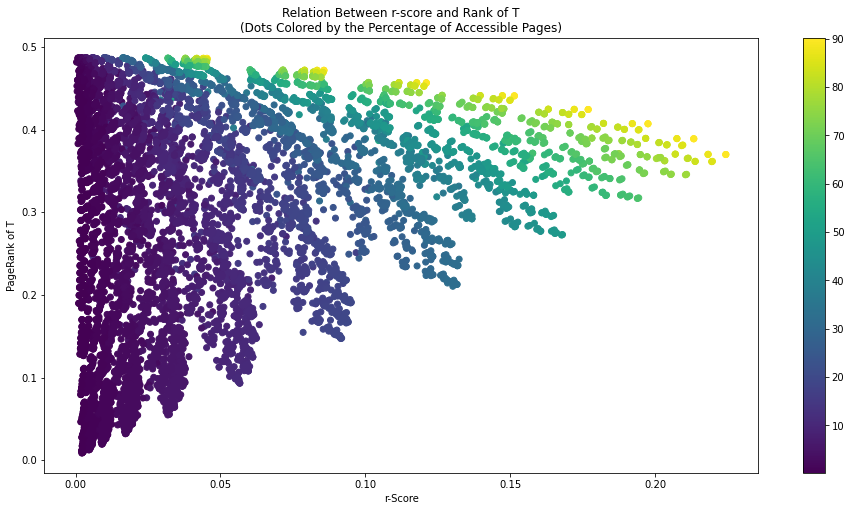

In [6]:
plt.figure(figsize=(16,8))
plt.scatter(df['r_score'],
            df['T_rank'], 
            c=percentage_of("n_accessible"),
            #cmap='Blues'
            )
plt.title("Relation Between r-score and Rank of T\n(Dots Colored by the Percentage of Accessible Pages)")
plt.xlabel('r-Score')
plt.ylabel('PageRank of T')
plt.colorbar()
plt.show()

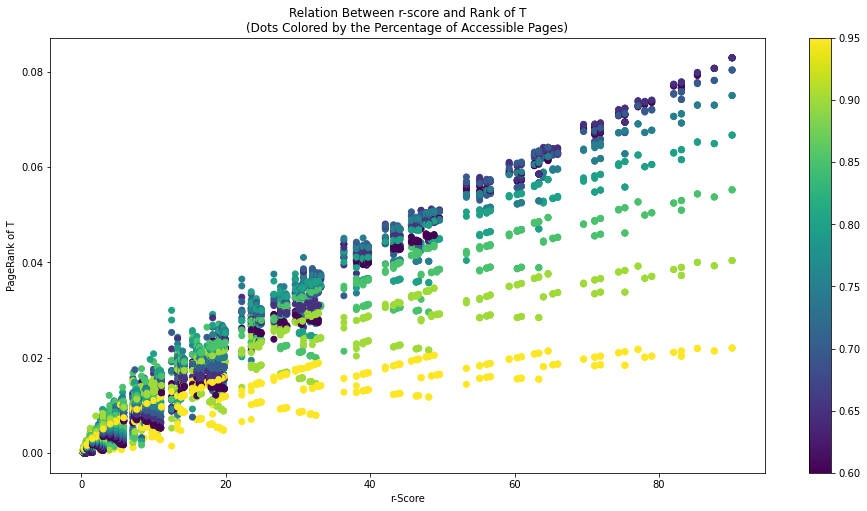

In [16]:
plt.figure(figsize=(16,8))
plt.scatter(percentage_of("n_accessible"),
            df['T_rank'] * df['r_score'],
            c=df['beta'],
            #cmap='Blues'
            )
plt.title("Relation Between r-score and Rank of T\n(Dots Colored by the Percentage of Accessible Pages)")
plt.xlabel('r-Score')
plt.ylabel('PageRank of T')
plt.colorbar()
plt.show()

Observations:
- Higher percentage of accessible vertices result with higher PageRank for T and higher r Score.

[]

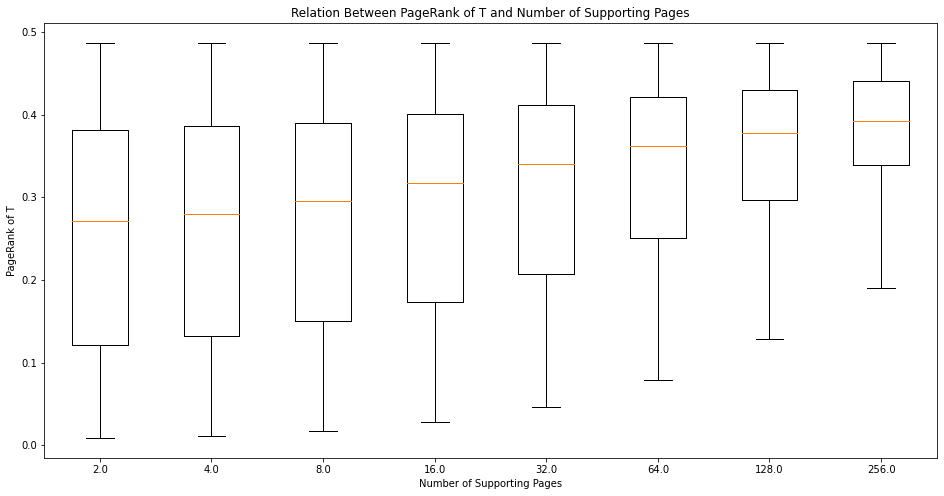

In [8]:
plt.figure(figsize=(16,8))
'''
plt.plot(df['n_supporting'], df['T_rank'], 
         linestyle='None',
         marker='o')'''
unique_n_supporting = df['n_supporting'].unique()
plt.boxplot([df[df['n_supporting']==v]['T_rank'] for v in unique_n_supporting],
            labels = unique_n_supporting)
plt.title("Relation Between PageRank of T and Number of Supporting Pages")
plt.xlabel('Number of Supporting Pages')
plt.ylabel('PageRank of T')
plt.plot()

[]

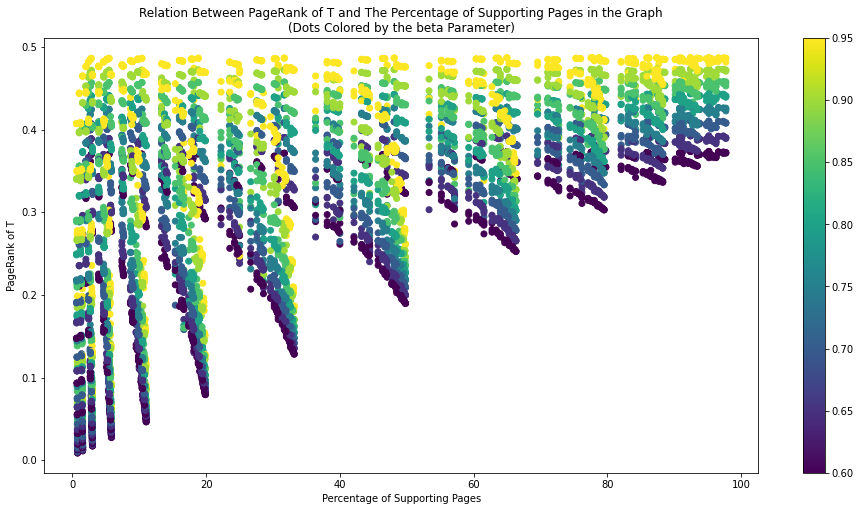

In [9]:
plt.figure(figsize=(16,8))
plt.scatter(percentage_of('n_supporting'),
            df['T_rank'],
            c=df['beta'])

plt.title("Relation Between PageRank of T and The Percentage of Supporting Pages in the Graph\n(Dots Colored by the beta Parameter)")
plt.xlabel('Percentage of Supporting Pages')
plt.ylabel('PageRank of T')
plt.colorbar()
plt.plot()

Observations:
- As the percentage of supporting vertices increases, minimum PageRank achieved in the search space increases.
- For higher values of beta, PageRank algorithm tends to give high rank scores to vertice T independent of the percentage of supporting nodes.

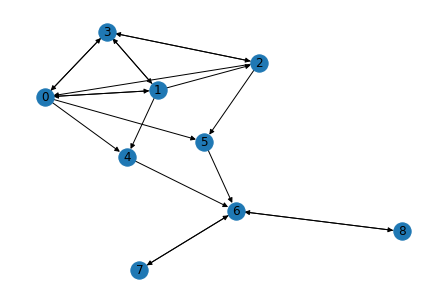

In [10]:
graph = Graph(4, 2, 2)
G = nx.convert_matrix.from_numpy_matrix(graph.adjacency.T, create_using=nx.DiGraph)
pos = nx.kamada_kawai_layout(G)
nx.draw(G,pos, with_labels=True)